In [1]:
import sys
import glob
import os
import ee
import math
import pandas as pd
import numpy as np
import geopandas as gp
import scipy.stats as stats

import matplotlib.pyplot as plt
import rsfuncs as rs

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Numeric NLCD vals to class labels
nlcd= {0: "Open water",
1 : "Perennial ice/snow",
2 : "Developed",
3 : "Developed, low intensity",
4 : "Developed, medium intensity",
5 : "Developed high intensity",
6 : "Barren land (rock/sand/clay)",
7 : "Deciduous forest", 
8 : "Evergreen forest",
9 : "Mixed forest",
10 : "Dwarf scrub",
11 : "Shrub/scrub",
12 : "Grassland/herbaceous",
13 : "Sedge/herbaceous",
14 : "Lichens",
15 : "Moss",
16 : "Pasture/hay",
17 : "Cultivated crops",
18 : "Woody wetlands",
19 : "Emergent herbaceous wetlands"}


In [3]:
# Read data

In [4]:
data_dir = "../data"

states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]


In [5]:
# Read and format the RS data 

df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

# Remove outliers
# df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

In [6]:
# Filter the data. 

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]
df = df[df.lc_type != 4]
df = df[df.lc_type != 5]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

In [7]:
# Select the filtered sites from the shapefile

In [8]:
validsites = [x for x in sites.id if int(x) in df.site.unique()]
sites = sites[sites.id.isin(validsites)]

In [9]:
# Join the scan data and rs data

# Scan join cols
join_cols = ["id","elev", "clay_fract", "silt_fract", "sand_fract", "a", "b"]
jdf = sites[join_cols]

In [10]:
df = pd.merge(df, jdf.astype(float), right_on= "id", left_on= "site", how = "inner")

In [11]:
df.columns

Index(['site', 'date', 'precip', 'rzsm', 'psi_rz', 'ssm', 'psi_s', 'lc_type',
       'vv', 'hv', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B1_filt',
       'B2_filt', 'B3_filt', 'B4_filt', 'B5_filt', 'B6_filt', 'B7_filt', 'id',
       'elev', 'clay_fract', 'silt_fract', 'sand_fract', 'a', 'b'],
      dtype='object')

### Compute the depth weighted root zone soil moisture for each site

Based on Jackson et al., 1996:

https://www.agro.uba.ar/users/sala/pdfs/063-oecol96c.pdf

Jackson, R. B., Canadell, J., Ehleringer, J. R., Mooney, H. A., Sala, O. E., & Schulze, E. D. (1996). A global analysis of root distributions for terrestrial biomes. Oecologia, 108(3), 389-411.

#### Equation 1:  $ Y =  1- \beta ^d $

Y is root density, d is depth, $\beta$ is empirical parameter

#### From table 1
grasses: $\beta$ = 0.952
trees: $\beta$ = 0.970
shrubs: $\beta$ = 0.978
...

In [12]:
def calc_y(depth,beta):
    y = 1-beta**depth
    return y

def calc_weighted_avg(ys):
    return [x/sum(ys) for x in ys]

In [13]:
# These beta values correspond to landcover types in NLCD 
beta_dict = { 
        12: 0.952,
        11: 0.978,
        17: 0.961,
        7: 0.970,
        16: 0.952,
        8: 0.970,
        6: 0.914, 
        }

In [14]:
# Now loop through each site id, read the SCAN soil moisture from data dir, compute the depth averaged SM

In [15]:
# Helper to read a SCAN site text file and return the data as a dataframe 

def read_sm_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df


In [16]:
# Heres the big loop

In [18]:
# Setup the results datastructures 
spatial_stats = {}
temporal_stats = {}
out_dfs = []

for idx, row in sites.iterrows():
        
    print("Processings site no {}".format(row.id))
    
    # Get the corresponding SCAN data file from data folder
    site_id = row.id
    sm_file = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if site_id in x][0]
    sm_dat = read_sm_file(sm_file)
    sm_dat['Date'] =  pd.to_datetime(sm_dat['Date'], format='%Y%m%d %H:%M')
    sm_dat.set_index('Date', inplace=True)
    
    if sm_dat.empty:
        print("no valid data")
        continue 
    
    # Rename the columns to the depths in cm (approx)
    sm_dat.rename(columns= { 
                        sm_dat.columns[0]: "5",
                        sm_dat.columns[1]: "10",
                        sm_dat.columns[2]: "20",
                        sm_dat.columns[3]: "50",
                        sm_dat.columns[4]: "100"
                        }, inplace = True)
    
    # Eliminate whitespace and drop rows with nans 
    sm_dat = sm_dat.replace(r'^\s*$', np.nan, regex=True)
    sm_dat = sm_dat.dropna()
    
    if sm_dat.empty:
        print("no valid data")
        continue 
        
    # Get the RS data for that site 
    rsdf = df[df.id == int(row.id)]
    lct = rsdf.lc_type.unique()[0]
    beta = beta_dict[lct]
    
    # Calculate the weighted sum for each row 
    was = []
    for idx, x in sm_dat.iterrows():
        depths = x.index.values
        depths = [float(x) for x in depths]
        ys = [calc_y(x,beta) for x in depths]
        wa = calc_weighted_avg(ys)
        wa = np.array(wa)
        smvals = [float(j) for j in x.values]
        weighted_sum = np.array(smvals*wa).sum()
        was.append(weighted_sum)
    
    # append the weighted sums to the dataframe 
    sm_dat['ws'] = was
    sm_dat = sm_dat.rename(columns={"5": "d5", "10": "d10", "20":"d20", "50": "d50", "100":"d100"})
    
    # Get the site specific mean and STD for all times 
    spatial_stats[row.id] = [np.mean(sm_dat.ws),np.std(sm_dat.ws)**2]

    # Get the temporal mean / std for 3 am - 7 am each day 
    opt = sm_dat[sm_dat.index.hour == 6].ws.values
    temporal_stats[row.id] = [np.mean(opt), np.std(opt)**2]
    
    # For all the dates with RS data, extract the depth averaged sm and join it to the master df
    sdf = df[df.site == int(row.id)]
    sdf.set_index(pd.to_datetime(sdf.date), inplace = True)
    dates = sdf.index
    
    rzsm = []

    for i in dates:
        starttime = i.replace(second=0, microsecond=0, minute=0, hour=3)
        endtime = starttime+timedelta(hours= 4)
        ddf = pd.DataFrame(sm_dat[starttime:endtime])
        rzsm.append(ddf)
        
    resampled = pd.concat(rzsm).resample("D").mean()
    sdf = sdf.resample("D").mean()
    
    final = pd.merge(sdf, resampled, left_index = True, right_index = True, how = "inner").dropna()
    
    out_dfs.append(final)

Processings site no 2214
no valid data
Processings site no 2215
Processings site no 2189
Processings site no 2190
Processings site no 2187
Processings site no 2183
Processings site no 2191
Processings site no 2192
Processings site no 2185
Processings site no 2184
Processings site no 2218
Processings site no 2149
Processings site no 2217
Processings site no 2186
Processings site no 2219
Processings site no 2197
Processings site no 2148
no valid data
Processings site no 674
no valid data
Processings site no 2117
Processings site no 2019
Processings site no 2121
Processings site no 581
Processings site no 2119
Processings site no 808
Processings site no 2118
Processings site no 2111
Processings site no 2069
Processings site no 2015
Processings site no 2172
Processings site no 2107
Processings site no 2168
Processings site no 2169
Processings site no 2171
Processings site no 2108
Processings site no 2216
no valid data
Processings site no 2145
Processings site no 2141
Processings site no 21

In [19]:
analysis_df = pd.concat(out_dfs)

In [20]:
analysis_df.to_csv("../data/FINAL_DATA.csv")

In [25]:
# Compile the spatial and temporal stats 

tempdf = []

for k,v in temporal_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_t'] = v[0]
    sdf['sm_var_t'] = v[1]
    tempdf.append(sdf)

spatialdf = []

for k,v in spatial_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_s'] = v[0]
    sdf['sm_var_s'] = v[1]
    spatialdf.append(sdf)

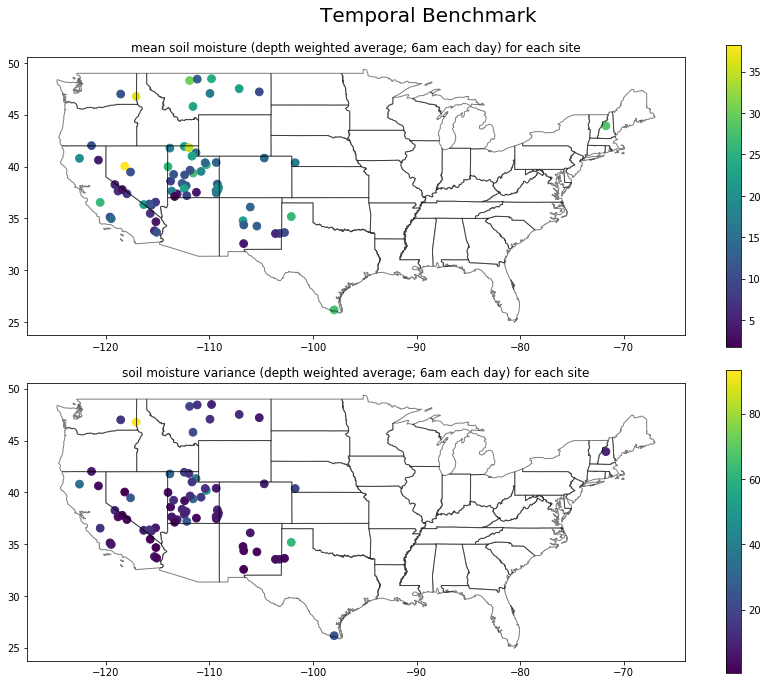

In [26]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Temporal Benchmark", size = 20)

ax[0].set_title("mean soil moisture (depth weighted average; 6am each day) for each site")
pd.concat(tempdf).plot(ax = ax[0], column = "sm_mean_t",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("soil moisture variance (depth weighted average; 6am each day) for each site")
pd.concat(tempdf).plot(ax = ax[1], column = "sm_var_t",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

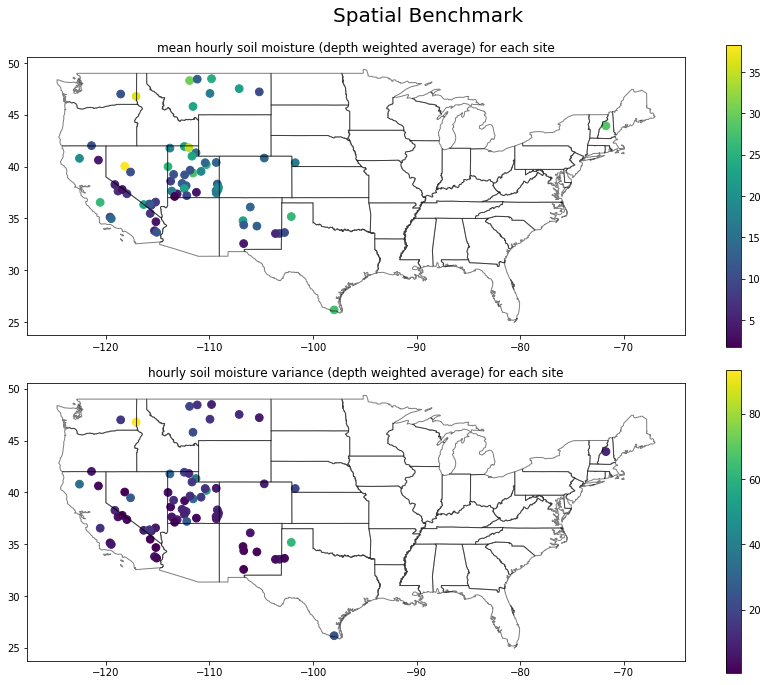

In [27]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Spatial Benchmark", size = 20)

ax[0].set_title("mean hourly soil moisture (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[0], column = "sm_mean_s",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("hourly soil moisture variance (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[1], column = "sm_var_s",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

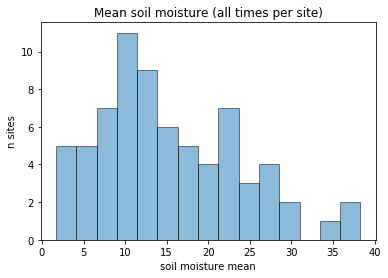

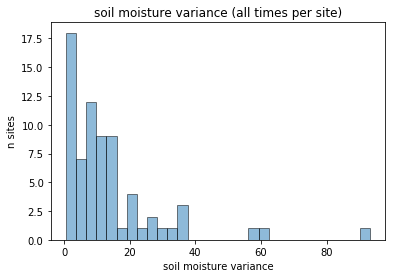

In [28]:
plt.hist(pd.concat(tempdf).sm_mean_t.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (all times per site)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(tempdf).sm_var_t.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (all times per site)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

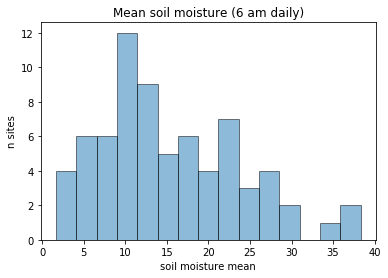

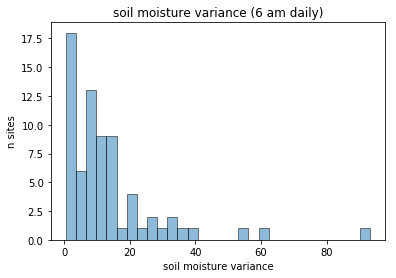

In [29]:
plt.hist(pd.concat(spatialdf).sm_mean_s.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (6 am daily)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(spatialdf).sm_var_s.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (6 am daily)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

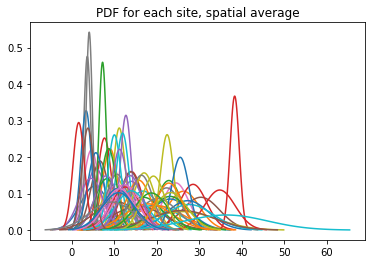

Text(0.5, 1.0, 'PDF for each site, temporal average')

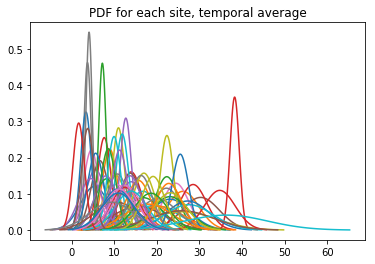

In [30]:
for k,v in spatial_stats.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, spatial average")
plt.show()

for k,v in temporal_stats.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, temporal average")

In [31]:
meandiff = {}
vardiff = {}
for k,v in spatial_stats.items():
    meandiff[k] = (v[0] - temporal_stats[k][0]) * 100
    vardiff[k] = (v[1] - temporal_stats[k][1]) * 100

In [32]:
mean_df = []

for k,v in meandiff.items():
    sdf = sites[sites.id == k]
    sdf['meandiff'] = v
    mean_df.append(sdf)

In [33]:
var_df = []

for k,v in vardiff.items():
    sdf = sites[sites.id == k]
    sdf['vardiff'] = v
    var_df.append(sdf)

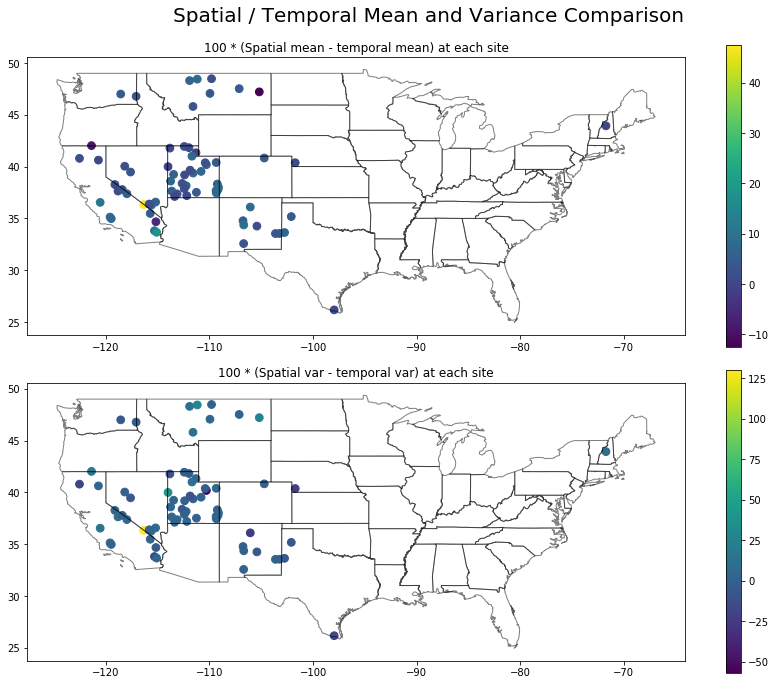

In [34]:
pd.concat(mean_df)
pd.concat(var_df)

fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Spatial / Temporal Mean and Variance Comparison", size = 20)

ax[0].set_title("100 * (Spatial mean - temporal mean) at each site")
pd.concat(mean_df).plot(ax = ax[0], column = "meandiff",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("100 * (Spatial var - temporal var) at each site")
pd.concat(var_df).plot(ax = ax[1], column = "vardiff",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# 

In [ ]:
site_lens = {}
lc_col = {}
for i in df.site.unique():
    sdf = df[df.site==i]
    site_lens[i] = (len(sdf))
    try:
        lc_col[i]= nlcd[sdf.lc_type[0]]
    except:
        continue

In [ ]:
t = pd.DataFrame.from_dict(list(site_lens.items()))
t.columns = ['site_id', 'len']

t2 = pd.DataFrame.from_dict(list(lc_col.items()))
t2.columns = ['site_id', 'type']

t = pd.merge(t,t2, on = "site_id")
# t.set_index('site_id', inplace = True);

In [ ]:
gdf = pd.merge(sites,t,how = "inner", left_index = True, right_index = True)

In [ ]:
fig, ax = plt.subplots(figsize = (12,5))

ax.set_title("N datapoints per site; total = {}".format(sum(site_lens.values())))
gdf.plot(ax = ax, column = "len", legend = True)
states.plot(ax = ax, color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)
plt.show()

In [ ]:
D = {}
for k,v in nlcd.items():
    t = df[df.lc_type == k]
    if len(t) == 0:
        continue
    else:
        D[v] = len(t)

In [ ]:
plt.figure(figsize = (15,7))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()), rotation='vertical', size = 15)
plt.yticks(size = 15)
plt.tight_layout()
plt.ylabel("n samples", size = 15)

In [ ]:
ts = []
for k,v in nlcd.items():
    t = df[df.lc_type == k]
    ts.append(t)

In [ ]:
lcdf = pd.concat(ts)

In [ ]:
join_cols = ["id","elev", "clay_fract", "silt_fract", "sand_fract", "a", "b"]
jdf = sites[join_cols]

In [ ]:
t = pd.merge(df, jdf.astype(float), right_on= "id", left_on= "site", how = "inner")

In [ ]:
out_dict = {}

In [ ]:
def read_sm_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df


In [ ]:

for idx, row in sites[20:22].iterrows():
    
    if row.id in out_dict.keys():
        print(row.id)
        continue
        
    print("Processings site no {}".format(row.id))
    
    # Get the corresponding SCAN data file from data folder
    site_id = row.id
    sm_file = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if site_id in x][0]
    sm_dat = read_sm_file(sm_file)
    sm_dat['Date'] =  pd.to_datetime(sm_dat['Date'], format='%Y%m%d %H:%M')
    sm_dat.set_index('Date', inplace=True)
    
    # Rename the columns to the depths in cm (approx)
    sm_dat.rename(columns= { 
                        sm_dat.columns[0]: "5",
                        sm_dat.columns[1]: "10",
                        sm_dat.columns[2]: "20",
                        sm_dat.columns[3]: "50",
                        sm_dat.columns[4]: "100"
                        }, inplace = True)
    
    # Eliminate whitespace and drop rows with nans 
    sm_dat = sm_dat.replace(r'^\s*$', np.nan, regex=True)
    sm_dat = sm_dat.dropna()
    
    
    
    


In [ ]:
sm_dat['rzsm'] = sm_dat * 

In [ ]:
validsites = [x for x in sites.id if int(x) in df.site.unique()]

In [ ]:
sites = sites[sites.id.isin(validsites)]

In [ ]:
sites.plot()

In [ ]:
pd.concat(spatialdf).columns

In [ ]:
depths = [2.,4., 8., 20., 40., ]
dcm = [2.54*x for x in depths]

In [ ]:
dcm

From: https://www.agro.uba.ar/users/sala/pdfs/063-oecol96c.pdf

Jackson, R. B., Canadell, J., Ehleringer, J. R., Mooney, H. A., Sala, O. E., & Schulze, E. D. (1996). A global analysis of root distributions for terrestrial biomes. Oecologia, 108(3), 389-411.

#### Equation 1:  $ Y =  1- \beta ^d $

Y is root density, d is depth, $\beta$ is empirical parameter

#### From table 1
grasses: $\beta$ = 0.952
trees: $\beta$ = 0.970
shrubs: $\beta$ = 0.978
...

In [ ]:
# Match the betas for each nlcd landcover type: 

for i in df.lc_type.unique():
    print(i)
    print(nlcd[i])
    print("==="*25)

In [ ]:
betas = { 
        12: 0.952,
        11: 0.978,
        17: 0.961,
        7: 0.970,
        16: 0.952,
        8: 0.970,
        6: 0.914, 
        }

In [ ]:
beta_dict = {
            'grass': 0.952,
            'trees': 0.970,
            'shrub': 0.978,
            'crops': 0.961,
            'barren': 0.914
            }

In [ ]:
def calc_y(depth,lctype):
    B = beta_dict[lctype]
    y = 1-B**depth
    return y

In [ ]:
grass = [calc_y(x,"grass") for x in dcm]
trees = [calc_y(x,"trees") for x in dcm]
shrubs = [calc_y(x,"shrub") for x in dcm]
crops = [calc_y(x,"crops") for x in dcm]
tundra = [calc_y(x,"barren") for x in dcm]


In [ ]:
plt.title("Cumulative root fraction as f(depth)")
plt.plot(grass, dcm, label = "grass")
plt.plot(trees, dcm, label = "trees")
plt.plot(shrubs, dcm, label = "shrubs")
plt.plot(crops, dcm, label = "crops")
plt.plot(tundra, dcm, label = "barren")

plt.gca().invert_yaxis()
plt.ylabel("root depth (cm)")
plt.xlabel("cumulative root fraction")
plt.legend()


In [ ]:
def calc_weighted_avg(depths):
    return [x/sum(depths) for x in depths]


In [ ]:
for i in grass

In [ ]:
df.lc_type

In [ ]:
# Calculate spectral indices

df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)


In [ ]:
# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 

vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))

In [ ]:
df['vv'] = vv_eff
df['hv'] = hv_eff

In [ ]:
for i in df.site.unique():
    sdf = df[df.site==i]
    dr = pd.date_range(start = sdf.index[0], end = sdf.index[-1], freq = "12D")
    dt_idx = pd.DataFrame(dr)
    dt_df = rs.col_to_dt(dt_idx)
    fdf = pd.merge(dt_df, sdf, how = "inner", left_index = True, right_index = True)

In [ ]:
def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

site_lags = {}
for j in df.site.unique():
    sdf = df[df.site==j]
    lags = []
    for i,x in enumerate(sdf.index[:-1]):
        lags.append((sdf.index[i+1] - sdf.index[i]).days)
    site_lags[j] = most_frequent(lags)
    
l = pd.DataFrame.from_dict(list(site_lags.items()))
l.columns = ['site_id', 'lags']


In [ ]:
plt.figure(figsize = (10,7))
plt.hist(site_lags.values(), bins = 50)
plt.xlabel("lagtime (days)")
plt.ylabel("n sites")
plt.show()

In [ ]:
gdf2 = pd.merge(sites,l,how = "inner", left_index = True, right_index = True)

In [ ]:
fig, ax = plt.subplots(figsize = (12,5))

cmap = plt.get_cmap('jet', 20)

ax.set_title("mean lagtime per site")
gdf2.plot(ax = ax, column = "lags", cmap = cmap, legend = True)
states.plot(ax = ax, color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)
plt.show()

In [ ]:
lag_lens = []
for i in df.site.unique():
    sdf = df[df.site==i]
    for i in sdf.index[2:-1]:
        end = i
        begin = end - pd.Timedelta(weeks=5)
        lag_lens.append(len(sdf.loc[begin:end]))

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(lag_lens, bins = 20)
plt.xlabel("n datapoints in 5 week window")
plt.ylabel("n samples")
plt.show()


In [ ]:
plt.figure(figsize = (10,7))
plt.hist(lag_lens, bins = 20)
plt.xlabel("n datapoints in 5 week window")
plt.ylabel("n samples")
plt.show()


In [ ]:
def calc_n_rows(window_size):
    filtered = []

    for i in df.site.unique():
        sdf = df[df.site==i]

        for i in sdf.index:                
            end = i
            begin = end - pd.Timedelta(days=window_size)
            t = sdf[sdf.date.between(begin, end)]
            num_points = len(t)
            if num_points>6:
                filtered.append(t)

    f = pd.concat(filtered).drop_duplicates(subset=['date', 'site'])
    
    return len(f)/2

In [ ]:
nrows = []
windows = np.linspace(30,60,31)

In [ ]:
for i in windows:
    nrows.append(calc_n_rows(i))

In [ ]:
plt.scatter(windows, nrows)
plt.ylabel("nrows")
plt.xlabel("timelag(days)")

In [ ]:
# calc the 12 day means for each site: 

len(df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna())


In [ ]:
def compute_lags(df, n=3):
    df['vv_t1'] = df['vv'].shift(1)
    df['hv_t1'] = df['hv'].shift(1)
    df['vv_t2'] = df['vv'].shift(2)
    df['hv_t2'] = df['hv'].shift(2)
    df['vv_t3'] = df['vv'].shift(3)
    df['hv_t3'] = df['hv'].shift(3)

    return df

In [ ]:
fdf = df.groupby(['site']).resample('12D').mean().fillna(np.nan)

In [ ]:
t = compute_lags(fdf)
# f = t.dropna()

In [ ]:
df

In [ ]:
# Filter out nonconsecutive dates
filtered = []

for i in t.site.unique():
    sdf = t[t.site==i]

    for i in sdf.index:   
        end = i[1]
        begin = end - pd.Timedelta(days=24)
        t = sdf[sdf.index.between(begin, end)]
        num_points = len(t)
        if num_points>6:
            filtered.append(t)


In [ ]:
df = None
df = t.dropna()

In [ ]:
# One hot encode the landcover types 
# one_hot = pd.get_dummies(df.lc_type, drop_first=True )
# X = pd.concat([X, one_hot], axis = 1)

In [ ]:
# Select dependent variable, drop fluff from input (independent) feats
y = df.psi_rz # Psi_RZ? 
X = df.drop(["site","rzsm", "ssm", "psi_rz", "psi_s", "lc_type"], axis=1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(np.array(y).reshape(-1, 1))

In [ ]:
# Train test split for validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale inputs
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.shape

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Modeling options
EPOCHS = int(20e3)
BATCHSIZE = int(2e5)
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l2(1e-5)
Breg = regularizers.l2(1e-3)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

In [ ]:
def build_model(input_shape=(X_train.shape[0], X_train.shape[1])):
    
    model = Sequential()
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                  return_sequences=True, \
                  bias_regularizer= Breg))
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                    return_sequences=True, \
                    bias_regularizer= Breg))
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                   bias_regularizer= Breg))

    model.add(Dense(1))
    
    model.compile(loss=LOSS, optimizer='adam')
    # fit network
    
    return model

In [ ]:
# model = build_model()

In [ ]:
# create and fit the LSTM network

input_shape=(X_train.shape[1], X_train.shape[2])

model = Sequential()

model.add(LSTM(100, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.05,\
              return_sequences=True, \
              bias_regularizer= Breg))
model.add(LSTM(50, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.05,\
                return_sequences=True, \
                bias_regularizer= Breg))
model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.05,\
               bias_regularizer= Breg))

model.add(Dense(1))
model.compile(loss="mape", optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=500, batch_size=10, verbose=1)

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

In [ ]:

trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
plt.scatter(y_train, trainPredict)
plt.show()
plt.scatter(y_test, testPredict)
plt.show()

In [ ]:
# Run the actual RF 

regressor = RandomForestRegressor(n_estimators=5000, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
# Make predictions on test data using the model trained on original data
predictions = regressor.predict(X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')